# Bee Image Classification using a CNN to detect Varroa mite infestation

#### Author: Mahdi Shadkam-Farrokhi: [GitHub](https://github.com/Shaddyjr) | [Medium](https://medium.com/@mahdis.pw) | [LinkedIn](https://www.linkedin.com/in/mahdi-shadkam-farrokhi-m-s-8a410958/) | [mahdis.pw](http://mahdis.pw)

## Problem Statement
Of the [many likely causes](https://www.sciencenewsforstudents.org/article/why-are-bees-vanishing-pesticides-disease-other-threats) behind the drastic decline in the honey bee population, the _Varroa (pronounced "vr-ow-uh") destructor_, or more commonly the _varroa mite_, is among the top contributors. As a natural predator to honey bees, the varroa mite is one of the biggest pests plaguing the bee keeping community. 


While small, these mites are difficult for bees to deal with. However, bee keepers can employ a number of treatments to help rid a hive of a varroa infestation. The sooner a bee keeper can begin treatment, the less likely a [colony collapse](https://ipm.missouri.edu/MPG/2013/7/Colony-Collapse-Disorder-the-Varroa-Mite-and-Resources-for-Beekeepers/) will occur.

Having an tool to quickly assess a colony's health could mean the difference between a healthy hive and a dead one. I plan to create that tool using the dataset from the [Honey Bee Annotated Image Dataset](https://www.kaggle.com/jenny18/honey-bee-annotated-images) found on Kaggle.

Using this dataset, I will use a Convolutional Neural Network to create a predictive model to determine if a bee image shows evidence of varroa mites or not (binary classification).

A bee hive with a varroa mite infestation can quickly end up dead from varroa collapse. As such, falsely classifying an image as clear could be disastrous. Therefore, recall, or sensativity, will be the metric I use for model selection.

## Table of contents

- [Data Dictionary](#Data-Dictionary)
- [Imports and loading Data](#Imports-and-loading-Data)
- [Preliminary EDA](#Preliminary-EDA)
    - [Handling target variable](#Handling-target-variable)
    - [Clearing unnecessary columns](#Clearing-unnecessary-columns)
    - [Visualizing file images](#Visualizing-file-images)
- [Source Documentation](#Source-Documentation)

## Data Dictionary
The data used for this analysis was taken directly from the [Honey Bee Annotated Image Dataset](https://www.kaggle.com/jenny18/honey-bee-annotated-images) fround on Kaggle.

The following is the data dictionary for the original dataset:

|column|type|description|
|-|-|-|
|file|string|name of file in 'bee_imgs' folder|
|date|string|date image was captured|
|time|string|time of day of image capture (military time)|
|location|string|Location (city, state, country)|
|zip|int| Zip code of the location|
|subspecies|string|Subspecies of _Apis mellifera_ species|
|health|string|Health of the bee|
|pollen_carrying|boolean|Presence of pollen on the bee's legs|
|caste|string|Worker, Drone, or Queen bee|

## Imports and loading Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import imageio
from skimage.transform import rescale, resize, rotate
from skimage.color import rgb2gray
from sklearn.metrics import confusion_matrix, auc, accuracy_score
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

import warnings
warnings.filterwarnings("ignore")

random_state = 42

# For reproducibility
np.random.seed(random_state)

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
data = pd.read_csv('./data/bee_data.csv')

In [3]:
data.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [4]:
data.shape

(5172, 9)

## Preliminary EDA

### Handling target variable

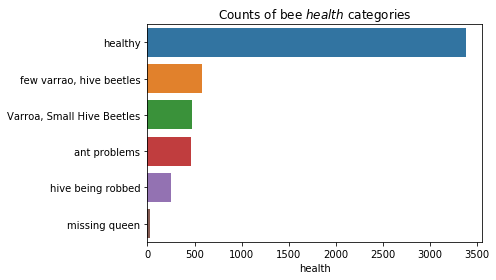

In [5]:
health_counts = data["health"].value_counts()

plt.title("Counts of bee $health$ categories")
sns.barplot(x = health_counts, y = health_counts.index);

The `healthy` and varroa-associated categories are the observations of interest and comprise the majority of total observations in the dataset. 

_The other observations will be dropped_

In [6]:
target_categories = [name for name in health_counts.index if "varr" in name.lower() or "health" in name.lower()]
data = data[[status in target_categories for status in data["health"]]]
data["has_varroa"] = (data["health"] != "healthy").astype(int)

In [7]:
data.shape

(4435, 10)

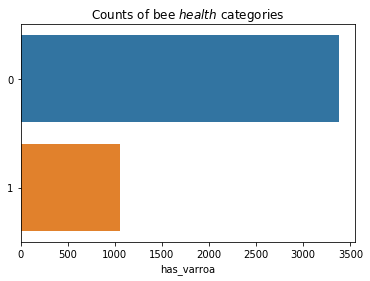

In [8]:
health_counts = data["has_varroa"].value_counts()

plt.title("Counts of bee $health$ categories")
sns.barplot(x = health_counts, y = health_counts.index, orient="h");

### Establishing baseline model

In [9]:
data["has_varroa"].value_counts(normalize = True)

0    0.763021
1    0.236979
Name: has_varroa, dtype: float64

These data are somewhat unbalanced, with the target variable `has_varroa` accounting for almost 24% of the data having the observation of interest.

With 76% of the dataset consisting of healthy bees, this serves as the baseline model's accuracy. Any model with an accuracy significantly higher than 76% can be considered superior to this naive model.

In [10]:
data.groupby("location").mean()[["has_varroa"]]

,has_varroa
location,
"Athens, GA, USA",1
"Athens, Georgia, USA",1
"Des Moines, IA, USA",0
"Keene, NH, USA",0
"New Orleans, LA, USA",0
"San Jose, CA, USA",0
"Saratoga, CA, USA",0


Apparently only two locations actually showcased varroa, which could train the model on factors unrelated to infected bees, such as classifying aspects of the location (parts of the image background) and/or the photographer's style (angle of shot, orientation, etc.).

### Clearing unnecessary columns
While a typical model would benefit from the image annotations, I'm attempting to make practical classifications based solely on a user's image. As such, most of the columns in the dataset are irrelevant.

In [11]:
data.head(1)

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste,has_varroa
74,017_029.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker,0


In [12]:
data = data[["file","has_varroa"]]
data.head(2)

,file,has_varroa
74,017_029.png,0
75,017_015.png,0


###  Visualizing file images
Viewing the actual images that will be used to train the CNN may help inform how best to approach potentially cleaning and/or preparing the images for classification training.

In [13]:
def get_images(files):
    IMAGE_FILE_ROOT = './data/bee_imgs/' 
    return np.asanyarray([imageio.imread("{}{}".format(IMAGE_FILE_ROOT, file)) for file in files])

In [14]:
images = get_images(data["file"])

In [15]:
def show_image(image, ax = plt, title = None, show_size = False):
    ax.imshow(image)
    if title:
        ax.set_title(title)
    if not show_size:
        ax.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)

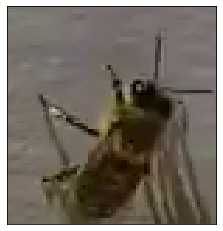

In [16]:
show_image(images[0])

In [17]:
def show_images(files, titles = None):
    cols = 4
    f, ax = plt.subplots(nrows=int(np.ceil(len(files)/cols)),ncols=cols, figsize=(14,8))
    ax = ax.flatten()
    for i, file in enumerate(files):
        if titles:
            show_image(file, ax = ax[i], title = titles[i])
        else:
            show_image(file, ax = ax[i], title = None)
    plt.show()

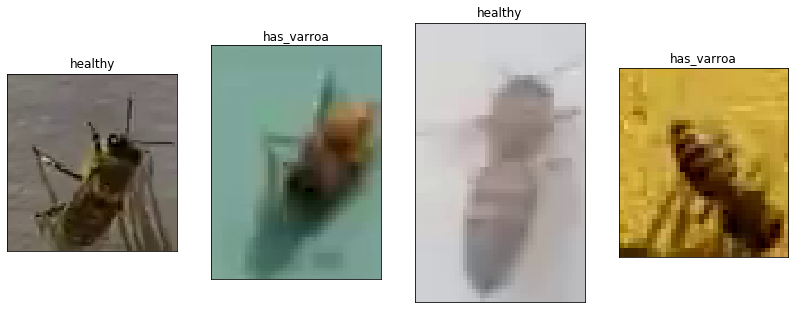

In [18]:
show_images(images[::1200],list(data["has_varroa"].map({1:"has_varroa",0:"healthy"})[::1200]))

These pixelated images will be digested and processed by the CNN to descern the bee's classfication. 

However, from quickly viewing just a handful of these images, I'm concerned about the low resolution and inconsistent quality of the data. For example, the 2nd image above shows a bee with varroa, which appears as little more than a blob. 

Can a CNN accurately discern the difference between one blob and another? If it can, is it really learning to distinguish an infected bee from a healthy one, or is it learning to distinguish something else, like the background?

Additionally, I'm concerned the inconsistent image sizes may pose a problem when inputting the pixel data into the convolutional layer. These images will need to be standardized, and using either resizing or rescaling will either lose data or distort the image (effectively using augmented data).

### Discovering most frequent image shape
Since the CNN will need a consistent format, I'll use the most frequent image size by default and transform any images not matching those parameters.

In [19]:
def get_image_sizes(images):
    out = {}
    for image in images:
        h, w, rbg = image.shape
        size = "{}x{}".format(h,w)
        if not out.get(size):
            out[size] = 0
        out[size] += 1
    return out

In [20]:
sizes = get_image_sizes(images)

In [21]:
max(sizes.values()) / sum(sizes.values())

0.0033821871476888386

Since only about .3% (12 total) of the total image data has the most frequent size, we'll have to rethink this approach. Instead, perhaps an average of the widths and heights can be used to coerce images to the same size.

In [22]:
def get_images_wh(images):
    widths = []
    heights = []
    for image in images:
        h, w, rbg = image.shape
        widths.append(w)
        heights.append(h)
    return (widths, heights)

In [23]:
def get_best_average(dist, cutoff = .5):
    # requires single peak normal-like distribution
    hist, bin_edges = np.histogram(dist, bins = 25);
    total_hist = sum(hist)
    hist_edges = [(vals[0]/total_hist,vals[1]) for vals in zip(hist, bin_edges)]
    hist_edges.sort(key = lambda x: x[0])
    lefts = []
    while cutoff > 0:
        vals = hist_edges.pop()
        cutoff -= vals[0]
        lefts.append(vals[1])
    diff = np.abs(np.diff(lefts)[0]) # same diff b/c of bins
    leftmost = min(lefts)
    rightmost = max(lefts) + diff
    return int(np.round(np.mean([rightmost,leftmost])))

In [24]:
wh = get_images_wh(images)

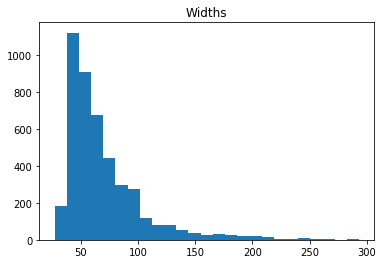

In [25]:
plt.title("Widths")
plt.hist(wh[0], bins = 25);

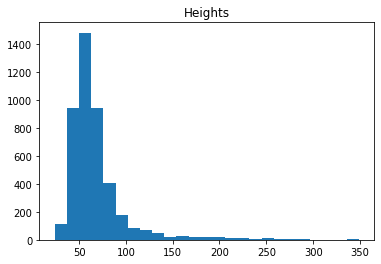

In [26]:
plt.title("Heights")
plt.hist(wh[1], bins = 25);

In [27]:
IDEAL_WIDTH, IDEAL_HEIGHT = get_best_average(wh[0]), get_best_average(wh[1])
IDEAL_WIDTH, IDEAL_HEIGHT

(54, 50)

These average widths will do the least to deform/alter the original image for the majority of the data.

## ImageHandler Class

[found here](./ImageHandler_doc.ipynb)

In [28]:
from image_handler import ImageHandler

## gridSearchCNN helper function

In [29]:
def get_image_data(files):
    IMAGE_FILE_ROOT = './data/bee_imgs/' 
    return np.asanyarray([imageio.imread("{}{}".format(IMAGE_FILE_ROOT, file)) for file in files])

In [30]:
raw_images = get_image_data(data["file"].values)

In [40]:
img_store = ImageHandler(raw_images).resize((IDEAL_WIDTH, IDEAL_HEIGHT, 3)).normalize()

In [41]:
X = img_store.images

y = data["has_varroa"].iloc[img_store.index]

In [49]:
def build_model(params, X_train, X_test, y_train_dummy, y_test_dummy):
    kernel_size = 3
    dropout = .5
    activation_func = "relu"
    input_shape = X_train[0].shape # deducing shape from input
    
    conv__filters_1 = params.get('conv__filters_1') or 16
    conv__filters_2 = params.get('conv__filters_2') or 32
    density_units_1 = params.get('density_units_1') or 32
    density_units_2 = params.get('density_units_2') or 16
    batch_size      = params.get('batch_size') or 64
    epochs          = params.get('epochs') or 8
    
    # instantiating model
    model = Sequential([
        Conv2D(
            filters = conv__filters_1, 
            kernel_size = kernel_size, 
            activation  = activation_func, 
            input_shape = input_shape
        ),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters = conv__filters_2, kernel_size = kernel_size, activation=activation_func),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(density_units_1, activation=activation_func),
        Dropout(dropout),
        Dense(density_units_2, activation=activation_func),
        Dropout(dropout),
        Dense(2, activation='softmax')
    ])
    
    # compiling model
    model.compile(
        loss      = 'binary_crossentropy',
        optimizer = 'adam',
        metrics   = ['binary_accuracy']
    )
    
    model.fit(X_train,
        y_train_dummy,
        batch_size = batch_size,
        validation_data = (X_test, y_test_dummy),
        epochs=epochs,
        verbose=0
    )
    return model

In [47]:
def gridSearchCNN(X, y, grid_params, random_state = None):
    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, stratify = y, random_state = random_state)

    # dummify y outcomes
    y_train_dummy = np_utils.to_categorical(y_train,2)
    y_test_dummy  = np_utils.to_categorical(y_test,2)
    
    all_params = permutate_params(grid_params) # list of all parameter combinations
    
    best_model = None
    best_score = 0.0 # no accuracy to start
    best_params = None
    
    for params in all_params:
        model = build_model(params, X_train, X_test, y_train_dummy, y_test_dummy)
        
        preds = model.predict_classes(X_test)
        acc = accuracy_score(y_test, preds)
        
        if acc > best_score:
            print("***Good Accurary found: {:.2%}***".format(acc))
            best_score = acc
            best_model = model
            best_params = params
            
    return {
        "best_model": best_model,
        "best_score": best_score,
        "best_params": best_params
    }
    

In [48]:
def permutate_params(grid_params):
    out = [{}]
    for param_name, param_list in grid_params.items():
        if len(param_list) == 1:
            for item in out:
                item[param_name] = param_list[0]
        else:
            temp_out = []
            for param_val in param_list:
                for item in out:
                    cloned_item = item.copy()
                    cloned_item[param_name] = param_val
                    temp_out.append(cloned_item)
            out = temp_out
    return out

In [50]:
grid_params = {
    "conv__filters_1" : [32],
    "conv__filters_2" : [16],
    "density_units_1" : [32],
    "density_units_2" : [32],
    "batch_size"      : [64]
}
best_model = gridSearchCNN(X, y, grid_params, random_state=random_state)

***Good Accurary found: 98.83%***
***Good Accurary found: 99.19%***


In [51]:
best_model

{'best_model': <keras.engine.sequential.Sequential at 0x1f62c859358>,
 'best_score': 0.9918845807033363,
 'best_params': {'conv__filters_1': 32,
  'conv__filters_2': 16,
  'density_units_1': 32,
  'density_units_2': 32,
  'batch_size': 64}}

### Resizing images
With an ideal height and width set, we can create a simple function responsible for handling the resizing.

In [ ]:
def resize_image(image, resizing = (28,28), preserve_range=True):
    return resize(image, resizing, anti_aliasing=True, mode = "constant", preserve_range = preserve_range)

In [ ]:
resizing = (IDEAL_WIDTH, IDEAL_HEIGHT, 3)
f, axes = plt.subplots(ncols = 4, figsize = (10,14))

old_image_1 = imageio.imread("./data/bee_imgs/017_100.png")
show_image(old_image_1, ax = axes[0], title = "Original Image #1", show_size = True)
new_image_1 = resize_image(old_image_1, resizing)
show_image(new_image_1, ax = axes[1], title = "Resized to standardized size", show_size = True)

old_image_2 = imageio.imread("./data/bee_imgs/017_010.png")
show_image(old_image_2, ax = axes[2], title = "Original Image #2", show_size = True)
new_image_2 = resize_image(old_image_2, resizing)
show_image(new_image_2, ax = axes[3], title = "Resized to standardized size", show_size = True)
plt.tight_layout()

For the most part, the images are not terribly perturbed by resizing them to a standard width and height. Of course, these augmented images must be taken into consideration when interpreting the results and the applicability of the model to real world images, which may require a more nuanced method for standardizing incoming images.

## Model Preparation
We may want to consider boosting (bootstrapping) the minority class (has_varroa), given unbalanced classes.

Found some advice for working with CNN - [source](https://victorzhou.com/blog/keras-cnn-tutorial/)

In [ ]:
def get_image_data(files, resizing):
    '''Normalizes ...............'''
    IMAGE_FILE_ROOT = './data/bee_imgs/' 
    return (np.asanyarray([resize_image(imageio.imread("{}{}".format(IMAGE_FILE_ROOT, file)), resizing) for file in files]) / 255) - 0.5

In [ ]:
resizing = (IDEAL_WIDTH, IDEAL_HEIGHT, 3) # needed to remove 4th alpha channel

X = get_image_data(data["file"], resizing)

y = data["has_varroa"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, stratify = y, random_state = random_state)

y_train_dummy = np_utils.to_categorical(y_train,2)
y_test_dummy  = np_utils.to_categorical(y_test,2)

In [ ]:
def conf_matrix_stats(y_test, preds):
    ''' Return key confusion matrix metrics given true and predicted values'''
    cm = confusion_matrix(y_test, preds)
    TP, FP, FN, TN, = cm[1,1], cm[0,1], cm[1,0], cm[0,0]
    total = (TP + FP + FN + TN)
    acc = (TP + TN ) / total
    miss = 1 - acc
    sens = TP / (TP + FN)
    spec = TN / (TN + FP)
    prec = TP / (TP + FP)
    return {"accuracy": acc, "miss_rate": miss, "sensitivity": sens, "specification": spec, "precision": prec}

In [ ]:
initial_filters = 16
density_units = 32

batch_size = 64
epochs = 16

kernel_size = 3
dropout = .5
activation_func = "relu"

# Instantiate a CNN.
cnn_model_2 = Sequential()

# Add a convolutional layer.
cnn_model_2.add(Conv2D(filters   = initial_filters,         # number of filters
                     kernel_size = kernel_size,        # height/width of filter
                     activation  = activation_func,      # activation function 
                     input_shape = (IDEAL_WIDTH,IDEAL_HEIGHT,3)) # shape of input (image)
               )

# Add a pooling layer.
cnn_model_2.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling

# Add another convolutional layer.
cnn_model_2.add(Conv2D(filters = initial_filters * 2,
                       kernel_size = kernel_size,
                       activation=activation_func))

# Add another pooling layer.
cnn_model_2.add(MaxPooling2D(pool_size=(2,2)))

# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_model_2.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_model_2.add(Dense(density_units * 2, activation=activation_func))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(dropout))

# Add a densely-connected layer with 32 neurons.
cnn_model_2.add(Dense(density_units, activation=activation_func))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(dropout))

# Add a final layer with 2 neurons.
cnn_model_2.add(Dense(2, activation='softmax'))

# Compile model
cnn_model_2.compile(loss='binary_crossentropy',
                    optimizer="adam",
                    metrics=["binary_accuracy"])

# Fit model on training data
history = cnn_model_2.fit(X_train,
                          y_train_dummy,
                          batch_size=batch_size,
                          validation_data=(X_test, y_test_dummy),
                          epochs=epochs,
                          verbose=1)

In [ ]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(len(test_loss)), labels = range(1,len(test_loss) + 1))
plt.legend(fontsize = 18);

In [ ]:
cnn_model_2.summary()

In [ ]:
predictions = cnn_model_2.predict_classes(X_test)

results = predictions - y_test
results.value_counts(normalize = True)

We see 1.11% of the test predictions were false positives, while .8% were false negatives.

In [ ]:
conf_matrix_stats(y_test, predictions)

This model's __accuracy is 99.2%__ with a specificity of 99.97% and a sensativity of 94.6%.

As this model performs much better than the baseline model, we can conclude this model is a more useful classifier.

## Evaluating Model Errors

#### False positives

In [ ]:
def show_bad_image(file, ax, title = None, IMAGE_FILE_ROOT = './data/bee_imgs/'):
    image = imageio.imread("{}{}".format(IMAGE_FILE_ROOT,file)) if type(file) == str else file
    shape = image.shape
    if title:
        ax.set_title(f"Orig. size: {shape[0]}x{shape[1]}\n{title}")
    ax.imshow(resize_image(image, resizing, preserve_range = False))
    ax.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)
    return image

In [ ]:
def show_bad_images(files, titles = None, ncols = 4, height = 4):
    nrows = int(np.ceil(len(files)/ncols))
    f, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=(10,nrows * height))
    ax = ax.flatten()
    for i, file in enumerate(files):
            show_bad_image(file, ax = ax[i], title = titles[i] if titles else titles)
    plt.tight_layout()
    plt.show()

In [ ]:
false_positive_files = data.loc[results[results == -1].index]["file"]
show_bad_images(false_positive_files, ["false pos."] * len(false_positive_files))

We can see these false positives have some common issues that are likely throwing off the neural network.

1. __Rescaling artifacts__ - the rescaling step may have drastically altered the original image
2. __Orientation__ - many of the bees pictured here are upside-down. This may be remedied by retraining the network using rotated versions of the training data.
3. __Patterned background__ - a striped pattern is a signature part of the bee abdomen. Some of these falsely classified images could have been the result of the network mistaking the background for a larger bee with a "smaller" mite on it.
4. __Shadows__ - a number of these images display prominent shadows, which may have confused the network.

#### False negatives

In [ ]:
false_negative_files = data.loc[results[results == 1].index]["file"]
show_bad_images(false_negative_files, ["false neg."] * len(false_negative_files))

We can see these false negatives show some common issues as well:

1. __Shadows__ - like before, a number of these images display prominent shadows, which may have confused the network.
2. __Partials__ - many of these images show either more than 1 bee or only parts of bees. This could easily confuse the network, as these kinds of images are essentially incomplete.

## Retraining with rotated images

In [ ]:
def get_rotated_image_data(files, resizing, preserve_range = True, normalize = True):
    IMAGE_FILE_ROOT = './data/bee_imgs/'
    out = []
    for file in files:
        merger = []
        img = resize_image(imageio.imread("{}{}".format(IMAGE_FILE_ROOT, file)), resizing, preserve_range=preserve_range)
        if normalize:
            img = (img / 255) - .5
        merger.append(img)
        merger.extend([rotate(img, angle) for angle in range(90,360,90)])
        merger.extend([np.flipud(unflipped_img) for unflipped_img in merger])
        out.extend(merger)
    return np.asanyarray(out)

In [ ]:
show_bad_images(get_rotated_image_data(data["file"].iloc[0:1], resizing, preserve_range = False, normalize = False))

Each image is rotated in all 4 direction and mirrored. This ensures the model is trained on as many possible orientations as possible.

In [ ]:
new_X = get_rotated_image_data(data["file"], resizing)
new_y = np.repeat(y,8) # each image is replicated 8 times, essentially

X_train_rotated, X_test_rotated, y_train, y_test = train_test_split(new_X, new_y, test_size = .25, stratify = new_y, random_state = random_state)

y_train_dummy = np_utils.to_categorical(y_train,2)
y_test_dummy  = np_utils.to_categorical(y_test,2)

In [ ]:
initial_filters = 16
density_units = 32

batch_size = 64
epochs = 16

kernel_size = 3
dropout = .5
activation_func = "relu"

# Instantiate a CNN.
cnn_model_2 = Sequential()

# Add a convolutional layer.
cnn_model_2.add(Conv2D(filters   = initial_filters,         # number of filters
                     kernel_size = kernel_size,        # height/width of filter
                     activation  = activation_func,      # activation function 
                     input_shape = (IDEAL_WIDTH,IDEAL_HEIGHT,3)) # shape of input (image)
               )

# Add a pooling layer.
cnn_model_2.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling

# Add another convolutional layer.
cnn_model_2.add(Conv2D(filters = initial_filters * 2,
                       kernel_size = kernel_size,
                       activation=activation_func))

# Add another pooling layer.
cnn_model_2.add(MaxPooling2D(pool_size=(2,2)))

# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_model_2.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_model_2.add(Dense(density_units * 2, activation=activation_func))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(dropout))

# Add a densely-connected layer with 32 neurons.
cnn_model_2.add(Dense(density_units, activation=activation_func))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(dropout))

# Add a final layer with 2 neurons.
cnn_model_2.add(Dense(2, activation='softmax'))

# Compile model
cnn_model_2.compile(loss='binary_crossentropy',
                    optimizer="adam",
                    metrics=["binary_accuracy"])

# Fit model on training data
history = cnn_model_2.fit(X_train_rotated,
                          y_train_dummy,
                          batch_size=batch_size,
                          validation_data=(X_test_rotated, y_test_dummy),
                          epochs=epochs,
                          verbose=1)

In [ ]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(len(test_loss)), labels = range(1,len(test_loss) + 1))
plt.legend(fontsize = 18);

In [ ]:
predictions2 = cnn_model_2.predict_classes(X_test)
results2 = predictions2 - y_test
results2.value_counts(normalize = True)

In [ ]:
conf_matrix_stats(y_test, predictions2)

In [ ]:
false_positive_files = data.loc[results2[results2 == -1].index]["file"].unique()
show_bad_images(false_positive_files, ["false pos."] * len(false_positive_files))

- Many images are completely lacking in definition
- Another noteworthy trend is the darker exoskeletons of certain species of bees, which make them more prone to being falsely classified. This model only takes the images as they are and does not take any additional data into account. If a bee "species" could be included, it would allow the model to more accurately distinguish darker bees with varroa mites.
- confusing background

In [ ]:
false_negative_files = data.loc[results2[results2 == 1].index]["file"].unique()
show_bad_images(false_negative_files, ["false neg."] * len(false_negative_files), ncols = 6, height = 2)

## Saving/Loading the model

In [ ]:
cnn_model_2.save_weights('cnn.h5')

In [ ]:
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

# num_filters = 8
# filter_size = 3
# pool_size = 2

# # Build the model.
# model = Sequential([
#   Conv2D(num_filters, filter_size, input_shape=(28, 28, 1)),
#   MaxPooling2D(pool_size=pool_size),
#   Flatten(),
#   Dense(10, activation='softmax'),
# ])

# # Load the model's saved weights.
# model.load_weights('cnn.h5')

## Removing color!
Removing color significantly lowers accuracy

In [ ]:
def grayscale_invert_images(images, add_dim = True):
    originals = np.asanyarray([rgb2gray(img) for img in images])
    inverted = 255 - originals
    out = np.concatenate([originals, inverted])
    
    if add_dim:
        return np.expand_dims(out, axis=3)
    return out

In [ ]:
X_gray_inv = grayscale_invert_images(new_X)
y_gray_inv = np.concatenate([new_y, new_y]) # each image is replicated 2 times, essentially

X_train_gray_inv, X_test_gray_inv, y_train, y_test = train_test_split(X_gray_inv, y_gray_inv, 
                                                                      test_size = .25, stratify = y_gray_inv, 
                                                                      random_state = random_state)
y_train_gray_inv_dummy = np_utils.to_categorical(y_train,2)
y_test_gray_inv_dummy  = np_utils.to_categorical(y_test,2)

In [ ]:
plt.imshow(np.squeeze(X_gray_inv[0]), cmap="gray");

In [ ]:
plt.imshow(np.squeeze(X_gray_inv[X_gray_inv.shape[0] // 2]), cmap="gray");

In [ ]:
initial_filters = 16
density_units = 32

batch_size = 64
epochs = 8

kernel_size = 3
dropout = .5
activation_func = "relu"

# Instantiate a CNN.
cnn_model_2 = Sequential([
    Conv2D(filters = initial_filters, kernel_size = kernel_size, 
           activation  = activation_func, input_shape = (IDEAL_WIDTH,IDEAL_HEIGHT, 1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters = initial_filters * 2, kernel_size = kernel_size, activation=activation_func),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(density_units * 2, activation=activation_func),
    Dropout(dropout),
    Dense(density_units, activation=activation_func),
    Dropout(dropout),
    Dense(2, activation='softmax')
])

# Compile model
cnn_model_2.compile(loss='binary_crossentropy',
                    optimizer="adam",
                    metrics=["binary_accuracy"])

# Fit model on training data
history = cnn_model_2.fit(X_train_gray_inv,
                          y_train_gray_inv_dummy,
                          batch_size=batch_size,
                          validation_data=(X_test_gray_inv, y_test_gray_inv_dummy),
                          epochs=epochs,
                          verbose=1)

# # Load the model's saved weights.
# cnn_model_2.load_weights('cnn.h5')

In [ ]:
predictions2 = cnn_model_2.predict_classes(X_test)
results2 = predictions2 - y_test
results2.value_counts(normalize = True)

In [ ]:
false_positive_files = data.loc[results2[results2 == -1].index]["file"].unique()
show_bad_images(false_positive_files, ["false pos."] * len(false_positive_files))

In [ ]:
false_negative_files = data.loc[results2[results2 == 1].index]["file"].unique()
show_bad_images(false_negative_files, ["false neg."] * len(false_negative_files), ncols = 6, height = 2)

With only 3 false negatives, this mod

## Just inverting image

97.4%

In [ ]:
def invert_images(images, add_dim = True):
    return 1 - images

In [ ]:
def _get_image_data(files, resizing):
    '''Normalizes ...............'''
    IMAGE_FILE_ROOT = './data/bee_imgs/' 
    return (np.asanyarray([resize_image(imageio.imread("{}{}".format(IMAGE_FILE_ROOT, file)), resizing, preserve_range=False) for file in files]))

In [ ]:
plt.imshow(X[0]);

In [ ]:
i_X = invert_images(X)

In [ ]:
plt.imshow(i_X[0])

In [ ]:
resizing = (IDEAL_WIDTH, IDEAL_HEIGHT, 3) # needed to remove 4th alpha channel

X = _get_image_data(data["file"], resizing)
i_X = invert_images(X)
X = np.concatenate([X,i_X])

y = np.concatenate([data["has_varroa"], data["has_varroa"]])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, stratify = y, random_state = random_state)

y_train_dummy = np_utils.to_categorical(y_train,2)
y_test_dummy  = np_utils.to_categorical(y_test,2)

In [ ]:
initial_filters = 16
density_units = 32

batch_size = 64
epochs = 20

kernel_size = 3
dropout = .5
activation_func = "relu"

# Instantiate a CNN.
cnn_model_2 = Sequential([
    Conv2D(filters = initial_filters, kernel_size = kernel_size, 
           activation  = activation_func, input_shape = (IDEAL_WIDTH,IDEAL_HEIGHT, 3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters = initial_filters * 2, kernel_size = kernel_size, activation=activation_func),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(density_units * 2, activation=activation_func),
    Dropout(dropout),
    Dense(density_units, activation=activation_func),
    Dropout(dropout),
    Dense(2, activation='softmax')
])

# Compile model
cnn_model_2.compile(loss='binary_crossentropy',
                    optimizer="adam",
                    metrics=["binary_accuracy"])

# Fit model on training data
history = cnn_model_2.fit(X_train,
                          y_train_dummy,
                          batch_size=batch_size,
                          validation_data=(X_test, y_test_dummy),
                          epochs=epochs,
                          verbose=1)

# # Load the model's saved weights.
# cnn_model_2.load_weights('cnn.h5')

In [ ]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(len(test_loss)), labels = range(1,len(test_loss) + 1))
plt.legend(fontsize = 18);

In [ ]:
predictions2 = cnn_model_2.predict_classes(X_test)
results2 = pd.Series(predictions2 - y_test)
results2.value_counts(normalize = True)

In [ ]:
false_positive_files = data.loc[results2[results2 == -1].index]["file"].unique()
show_bad_images(false_positive_files, ["false pos."] * len(false_positive_files))

## Visualizing the CNN
- https://www.analyticsvidhya.com/blog/2019/05/understanding-visualizing-neural-networks/
- https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
- https://datascience.stackexchange.com/questions/14899/how-to-draw-deep-learning-network-architecture-diagrams
- https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/
- http://alexlenail.me/NN-SVG/LeNet.html
- https://www.kdnuggets.com/2016/11/intuitive-explanation-convolutional-neural-networks.html/3
- https://datascience.stackexchange.com/questions/14899/how-to-draw-deep-learning-network-architecture-diagrams

In [ ]:
false_negative_files = data.loc[results2[results2 == 1].index]["file"].unique()
show_bad_images(false_negative_files, ["false neg."] * len(false_negative_files), ncols = 6, height = 2)

## ImageHandler class

Was very inconvenient working with image data, especially when wanting to transform the data for both modeling and visualization.

I created the ImageHandler class simply to alleviate the hassle of keeping track of image data, while also allowing for intuitive transformations in a consolidated way.

In [ ]:
def get_image_data(files):
    IMAGE_FILE_ROOT = './data/bee_imgs/' 
    return [imageio.imread("{}{}".format(IMAGE_FILE_ROOT, file)) for file in files]

In [ ]:
raw_images = get_image_data(data["file"].values)

from image_handler import ImageHandler

img_store = ImageHandler(raw_images)

ImageHandler._images.shape

# TO DO 
- Organize code w/OOP or functional design
- ~~try grayscale w/inverted colors (no good)~~

# Part 3

## Overview

Progress report due Monday August 12, 2019.

The finish line is in sight! You should have your data in hand and some models made. This portion of the Capstone contains two parts to help really hone your model and develop mastery over your final project.

*Goal*: A written progress report on your project and a detailed 1:1 with your instructor.

---

## Requirements

The actual deliverable for this section is fairly small. You are expected to submit, via [this Google form](https://forms.gle/ci7maWp4G5wRHdwH8), a progress report detailing where you are with your Capstone. The format and content is up to you but, at a minimum, we expect the following:

1. Do you have data fully in hand and if not, what blockers are you facing?
2. Have you done a full EDA on all of your data?
3. Have you begun the modeling process? How accurate are your predictions so far?
4. What blockers are you facing, including processing power, data acquisition, modeling difficulties, data cleaning, etc.? How can we help you overcome those challenges?
5. Have you changed topics since your lightning talk? Since you submitted your Problem Statement and EDA? If so, do you have the necessary data in hand (and the requisite EDA completed) to continue moving forward?
6. What is your timeline for the next week and a half? What do you _have_ to get done versus what would you _like_ to get done?
7. What topics do you want to discuss during your 1:1?

We will use your progress report as a leaping off point for a deep 1:1 with a member of the instructional staff. The best use of your time is to really flesh out this document so that your remaining time here can be most productive.

Submit this document no later than *end of day, August 12, 2019*.

## Necessary Deliverables / Submission

- Your progress report (touching on the points above) submitted no later than *end of day, August 12, 2019* on [this form](https://forms.gle/ci7maWp4G5wRHdwH8).

## Source Documentation
- [Honey Bee Annotated Image Dataset (Kaggle)](https://www.kaggle.com/jenny18/honey-bee-annotated-images)